# Kernel Density Estimation


This is just a collection of example gists, working towards a re-usable function.

https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html  
https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/  
https://mglerner.github.io/posts/histograms-and-kernel-density-estimation-kde-2.html?p=28  

https://github.com/tommyod/KDEpy  
https://kdepy.readthedocs.io/en/latest/examples.html   

https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0  
https://towardsdatascience.com/how-to-find-probability-from-probability-density-plots-7c392b218bab  
https://github.com/admond1994/calculate-probability-from-probability-density-plots/blob/master/cal_probability.ipynb  

https://stats.stackexchange.com/questions/405357/how-to-choose-the-bandwidth-of-a-kde-in-python  
https://www.homeworkhelponline.net/blog/math/tutorial-kde  

https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html  
https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation  
https://scikit-learn.org/stable/modules/density.html  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html  
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html  
  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html  
https://glowingpython.blogspot.co.za/2012/08/kernel-density-estimation-with-scipy.html  
https://pythonhosted.org/PyQt-Fit/KDE_tut.html  

Violin Plots  
https://www.mathsisfun.com/data/quartiles.html  
https://mode.com/blog/violin-plot-examples  
https://python-graph-gallery.com/violin-plot/  


Jake vdPlas makes a good point why and how histograms are not really good probability density estimators [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html#Motivating-KDE:-Histograms).  Depending on how the data points fall into the bins strange effects may arise.  He writes 'The problem with our two binnings stems from the fact that the height of the block stack often reflects not on the actual density of points nearby, but on coincidences of how the bins align with the data points. This mis-alignment between points and their blocks is a potential cause of the poor histogram results.

The histogram approach is to have (normally same-size) fixed bin edges, in to which the data points are falling and being counted. The Kernel Density method works the other way around make fixed-width block around each data point and add up the blocks' heights.  This way the weights add up around the data points' locations.  This is somewhat making a bin centred around each data point and then adding up the bin counts at a fine resolution.

Working with rectangular blocks the new density function has rough edges at the blocks' corners. The next logical step is to use smooth functions (called kernels) instead of rectangular blocks. This yields smooth functions with more appropriate density distributions than does the traditional histogram.  In this approach you must define/select the kernel shape and width. If the kernel is too wide a kernel's influence can be too wide, masking the data points. If the kernel is too narrow it will leave 'holes' between the data points. Just image a dirac delta kernel function which simply repeats the data set.

scikit-learn provides an efficient library for kernel density estimation. The library provides six different kernel shapes and a method whereby an appropriate  kernel width can be found.

This notebook investigates KDE as explained by JvdP and then develops a packaged function that can be readily used elsewhere.

This code requires a scikit learn version higher than 0.19. This work was done with version 0.20.1

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


In [33]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N) #mean-0 var=1
    # create bimodal data by adding const to  entries with index > f*N
    # this means that some of the date keep old values and some shift 
    x[int(f * N):] += 5
    return x

## Kernel concept

https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

The following code places a gaussian/normal distribution around each data point and adds them all up.

The principle here is that the gaussian placed at each data sample is a small kernel, the values of which are all added up.



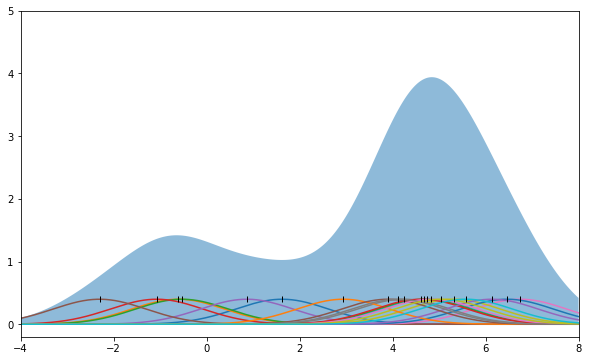

In [34]:

from scipy.stats import norm

plt.figure(figsize=(10,6))

x = make_data(20)
x_d = np.linspace(-4, 8, 1000)
for xi in x:
    plt.plot(x_d,norm(xi).pdf(x_d))
    
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, .4), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

Now use the scikit learn  functions to do the same

(-0.02, 0.22)

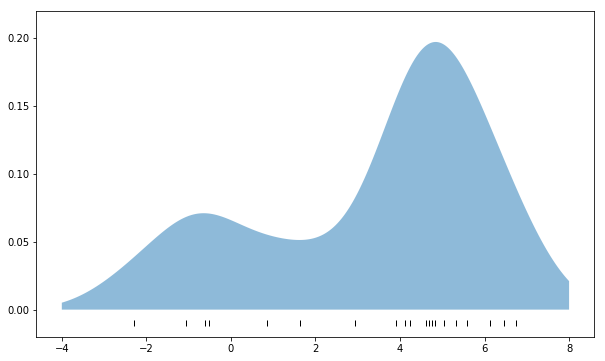

In [35]:
from sklearn.neighbors import KernelDensity

plt.figure(figsize=(10,6))

x = make_data(20)
x_d = np.linspace(-4, 8, 1000)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1, kernel='gaussian')
kde.fit(x[:, None]) # create additional axes of leng

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

https://kdepy.readthedocs.io/en/latest/examples.html#boundary-correction-using-mirroring


The gaussian kernels typically used in KDE reaches to infinity and the density function domain therefore spans infinity in x.
Suppose the data set is known to be bounded by zero on the lower end: non-zero values are not possible.
The KDE algorithm will happily return a nonzero density for $x<0$, so some means must be found to eliminate density outside the domain bounds.

In the next experiment make the data strictly positive, and observe that the PDF has nonzero density for x<0.
this is incorrect.


(-0.02, 0.22)

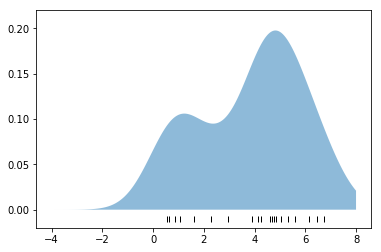

In [36]:
x = np.abs(make_data(20))
x_d = np.linspace(-4, 8, 1000)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1, kernel='gaussian')
kde.fit(x[:, None]) # create additional axes of length one

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None]) # create additional axes of length one

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

https://kdepy.readthedocs.io/en/latest/examples.html#boundary-correction-using-mirroring

To correct this non-zero density outside of the valid domain:

- Make additional datasets mirrored around the boundary or boundaries (if both sides are bounded).
- Calculated the KDE of each set separately: the base set, the lower set and the upper set.
- Add the result of the sets together.
- Select the results in the valid domain and set the values outside the valid domain to zero.

The procedure ensures that the PDF derivative at the boundary is zero.


(-0.02, 0.22)

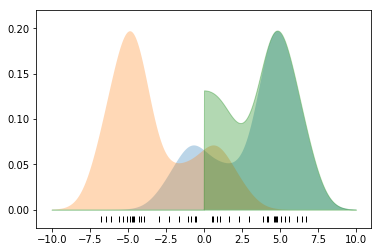

In [37]:
# single bound at 0

x = make_data(20)
x_d = np.linspace(-10, 10, 1000)

X = [x,-x]
Xo = []
for i,x in enumerate(X):
    # instantiate and fit the KDE model
    kde = KernelDensity(bandwidth=1, kernel='gaussian')
    kde.fit(x[:, None]) # create additional axes of length one

    # score_samples returns the log of the probability density
    logprob = kde.score_samples(x_d[:, None]) # create additional axes of length one
    Xo.append(np.exp(logprob))
    plt.fill_between(x_d, np.exp(logprob), alpha=0.3)
    plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    plt.ylim(-0.02, 0.22)
    
x = Xo[0] + Xo[1]
x = np.where(x_d<0,0,x)
plt.fill_between(x_d, x, alpha=0.3,color='g')
plt.ylim(-0.02, 0.22)


To extend to an upper and lower boundary, just repeat the process on both sides.

(-0.02, 0.22)

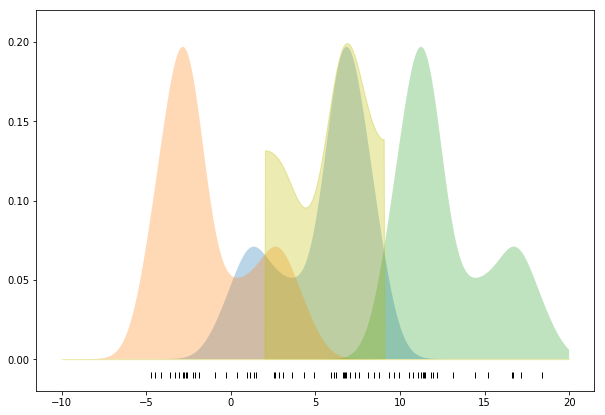

In [38]:
# two boundsL lower at fixed and upper at max of values + .3
lowbnd = 2
uppdelta = .3

# limit at lower bound
x = make_data(20) + lowbnd
uppbnd = np.max(x) + uppdelta

x_d = np.linspace(-10, 20, 1000)

X = []
Xo = []

# base data
X.append(x)
#flip lower bound  
y = -x + 2 * lowbnd
X.append(y)
# flip upper bound
y = -x + 2 * uppbnd
X.append(y)

plt.figure(figsize=(10,7))
for i,x in enumerate(X):
    # instantiate and fit the KDE model
    kde = KernelDensity(bandwidth=1, kernel='gaussian')
    kde.fit(x[:, None]) # create additional axes of length one

    # score_samples returns the log of the probability density
    logprob = kde.score_samples(x_d[:, None]) # create additional axes of length one
    Xo.append(np.exp(logprob))
    plt.fill_between(x_d, np.exp(logprob), alpha=0.3)
    plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
    plt.ylim(-0.02, 0.22)

x = np.zeros_like(x_d)
for xi in Xo:
    x += xi

x = np.where(x_d<=lowbnd,0,x)
x = np.where(x_d>=uppbnd,0,x)

plt.fill_between(x_d, x, alpha=0.3,color='y')
plt.ylim(-0.02, 0.22)


## Selecting the bandwidth

From JvdP book:
    
''The choice of bandwidth within KDE is extremely important to finding a suitable density estimate, and is the knob that controls the bias–variance trade-off in the estimate of density: too narrow a bandwidth leads to a high-variance estimate (i.e., over-fitting), where the presence or absence of a single point makes a large difference. Too wide a bandwidth leads to a high-bias estimate (i.e., under-fitting) where the structure in the data is washed out by the wide kernel.

There is a long history in statistics of methods to quickly estimate the best bandwidth based on rather stringent assumptions about the data: if you look up the KDE implementations in the SciPy and StatsModels packages, for example, you will see implementations based on some of these rules.

In machine learning contexts, we've seen that such hyperparameter tuning often is done empirically via a cross-validation approach. With this in mind, the KernelDensity estimator in Scikit-Learn is designed such that it can be used directly within the Scikit-Learn's standard grid search tools. Here we will use GridSearchCV to optimize the bandwidth for the preceding dataset. Because we are looking at such a small dataset, we will use leave-one-out cross-validation, which minimizes the reduction in training set size for each cross-validation trial''

We will not discuss the matter much deeper here, oher than to show how the kernel with optimisation can be done.  In the `KDEbounded` function below, if `bandwidth=np.nan` the bandwidth optimisation will be done.  If the `bandwidth`  is assigned a numerical value, that value will be used.

The Leave-One-Out algorithm used here is quite slow for large data sets. So use a smaller data set to determine the best bandwidth and then use the value numerically for the large runs.


## The main function

The following function encapsulates and generalises all of the preceeding discussion.  This function can be conveniently used elsewhere in your code.

In [39]:
def KDEbounded(x_d,x,bandwidth=np.nan,lowbnd=np.nan,uppbnd=np.nan,kernel = 'gaussian'):
    """Estimate the probability by Kernel Density Estimation

    If bandwidth is np.nan, calculate the optimal kernel width, aka bandwidth.  
    Be careful, this can take a while.

    Mirrors the data at either or both of the edges if the domain is bounded.

    Args:
        | x_d (np.array[N,]): domain over which values must be returned
        | x (np.array[N,]): sample data set
        | bandwidth (float): the kernel width to be used, np.nan if to be calculated
        | lowbnd (float): lower mirror fold boundary, np.nan means no lower bound and mirror
        | uppbnd (float): upper mirror fold boundary, np.nan means no upper bound and mirror
        | kernel (str): kernel to be used [‘gaussian’|’tophat’|’epanechnikov’|’exponential’|’linear’|’cosine’]


    Returns:
        | x_d (np.array[N,]): input vector used as domain for the calculations
        | x (np.array[N,]): probability density over x_d, the range of the PDF
        | bandwidth (float): bandwidth used in the KDE
        | kernel (str): kernel used 

    Raises:
        | No exception is raised.

    https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html#Motivating-KDE:-Histograms
    https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/
    https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
    https://stats.stackexchange.com/questions/405357/how-to-choose-the-bandwidth-of-a-kde-in-python
    https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html
    https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    https://stats.stackexchange.com/questions/405357/how-to-choose-the-bandwidth-of-a-kde-in-python
    https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
    https://towardsdatascience.com/how-to-find-probability-from-probability-density-plots-7c392b218bab
    https://github.com/admond1994/calculate-probability-from-probability-density-plots/blob/master/cal_probability.ipynb
   
    """

    from sklearn.neighbors import KernelDensity
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import LeaveOneOut
   
    
    # find optimal bandwidth if not supplied
    if np.isnan(bandwidth):
        bandwidths = 10 ** np.linspace(-1, 1, 100)
        kd = KernelDensity(kernel=kernel)
        grid = GridSearchCV(kd,param_grid={'bandwidth': bandwidths},
                            cv=LeaveOneOut())
        grid.fit(x[:, None]); # create additional axes of length one
        bandwidth = grid.best_params_['bandwidth']
 
    X = []
    Xo = []
    
    # base data, and if required lower flipped, upper flipped
    X.append(x)
    if not np.isnan(lowbnd):
        X.append(-x + 2 * lowbnd)
    if not np.isnan(uppbnd):
        X.append(-x + 2 * uppbnd)

    # do for base, and if present lower and upper flipped
    for i,x in enumerate(X):
        # instantiate and fit the KDE model
        kde = KernelDensity(bandwidth=bandwidth, kernel=kernel)
        kde.fit(x[:, None]) # create additional axes of length one
        # score_samples returns the log of the probability density
        prob = np.exp(kde.score_samples(x_d[:, None])) # create additional axes of length one
        Xo.append(prob)

    # add base and flipped together
    x = np.zeros_like(x_d)
    for xi in Xo:
        x += xi

    # only cut out the base domain
    if not np.isnan(lowbnd):
        x = np.where(x_d<=lowbnd,0,x)
    if not np.isnan(uppbnd):
        x = np.where(x_d>=uppbnd,0,x)
    
    return x_d,x,bandwidth, kernel


In [40]:
# helper function to set up experiments
def showexperiment(bounds=(np.nan,np.nan),bandwidth=np.nan,scale=1,offset=0,kernel='gaussian'):
    
    x = scale * make_data(20) + offset
    
    if not np.isnan(bounds[0]) and not np.isnan(bounds[1]):
        lowbnd = bounds[0]
        uppbnd = bounds[1]
        x_d = np.linspace(lowbnd,uppbnd, 1000)
    else:
        lowbnd = np.nan
        uppbnd = np.nan
        tenp = (np.max(x) - np.min(x)) / 10
        x_d = np.linspace(np.min(x)-tenp,np.max(x)+tenp, 1000)

    x_d,kde,bandwidth,kernel = KDEbounded(x_d,x,bandwidth=bandwidth,lowbnd=lowbnd,uppbnd=uppbnd, kernel=kernel)

    print(f'x.min={np.min(x):.4e}  x.max={np.max(x):.4e} x.shape={x.shape}')
    print(f'x.min={np.min(x_d):.4e}  x.max={np.max(x_d):.4e} x.shape={x_d.shape}')
    print(f'Bandwidth={bandwidth}')
    print(f'kernel={kernel}')
    print(f'Integral of PDF={np.trapz(kde,x_d)}')

    plt.figure(figsize=(10,7))
    plt.fill_between(x_d, kde, alpha=0.3,color='y')
    plt.plot(x, np.full_like(x, -0.011*np.max(kde)), 'ok', markeredgewidth=1)
    plt.xlim(np.min(x_d),np.max(x_d))
    plt.xlabel('$x_d$')
    plt.ylabel(f'Probability density')

The first example has is unbounded, i.e., the PDF can extend to any value on $x\in {\rm I\!R}$. The plots only show 10% wider than the input data on either side.

x.min=-2.3015e+00  x.max=6.7448e+00 x.shape=(20,)
x.min=-3.2062e+00  x.max=7.6494e+00 x.shape=(1000,)
Bandwidth=1.1233240329780276
kernel=gaussian
Integral of PDF=0.9607252940685365


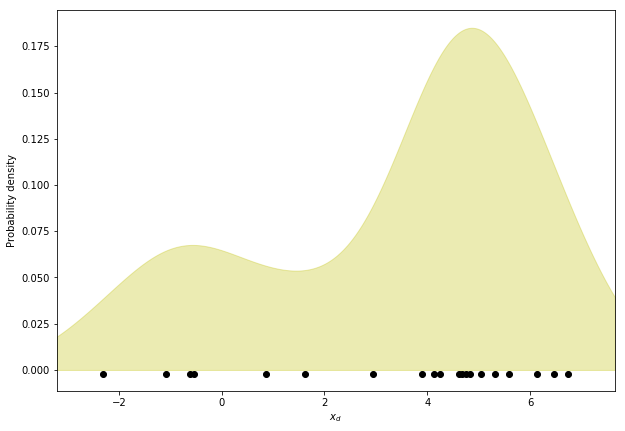

In [41]:
showexperiment()    

Now limit the domain for the PDF, in this case corresponding to the minimum and maximum input values.

x.min=-2.3015e+00  x.max=6.7448e+00 x.shape=(20,)
x.min=-2.3010e+00  x.max=6.7448e+00 x.shape=(1000,)
Bandwidth=1.1233240329780276
kernel=gaussian
Integral of PDF=0.9988190205097955


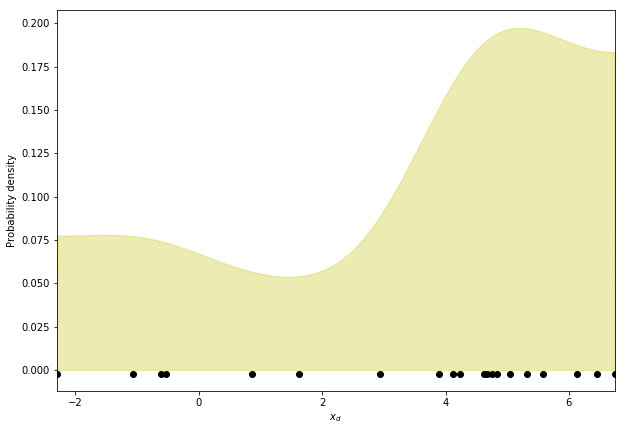

In [42]:
showexperiment(bounds=[-2.301,6.74481], bandwidth=np.nan, scale=1,offset=0)    

Limit the domain for the PDF, somewhat wider than the  minimum and maximum input values.

x.min=-2.3015e+00  x.max=6.7448e+00 x.shape=(20,)
x.min=-3.3010e+00  x.max=7.7448e+00 x.shape=(1000,)
Bandwidth=1.1233240329780276
kernel=gaussian
Integral of PDF=0.9994299785818043


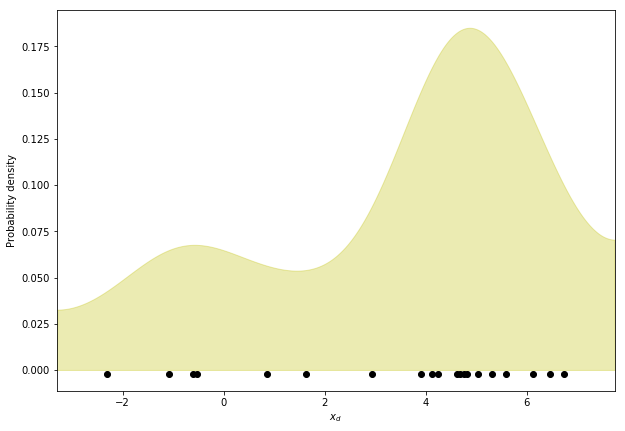

In [43]:
showexperiment(bounds=[-3.301,7.74481], bandwidth=np.nan, scale=1,offset=0)    

Repeat the previous but use the top hat kernel

x.min=-2.3015e+00  x.max=6.7448e+00 x.shape=(20,)
x.min=-3.3010e+00  x.max=7.7448e+00 x.shape=(1000,)
Bandwidth=1.7886495290574351
kernel=tophat
Integral of PDF=0.9995783653125939


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:791: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


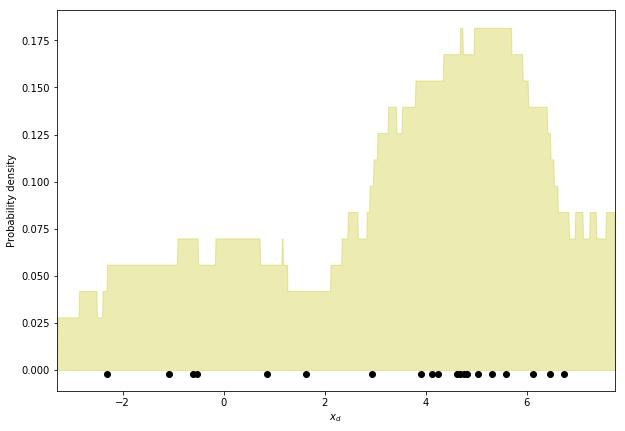

In [44]:
showexperiment(bounds=[-3.301,7.74481], bandwidth=np.nan, scale=1,offset=0,kernel = 'tophat')    

Repeat the previous but use a narrower top hat kernel

x.min=-2.3015e+00  x.max=6.7448e+00 x.shape=(20,)
x.min=-3.3010e+00  x.max=7.7448e+00 x.shape=(1000,)
Bandwidth=0.1
kernel=tophat
Integral of PDF=1.0006464514514513


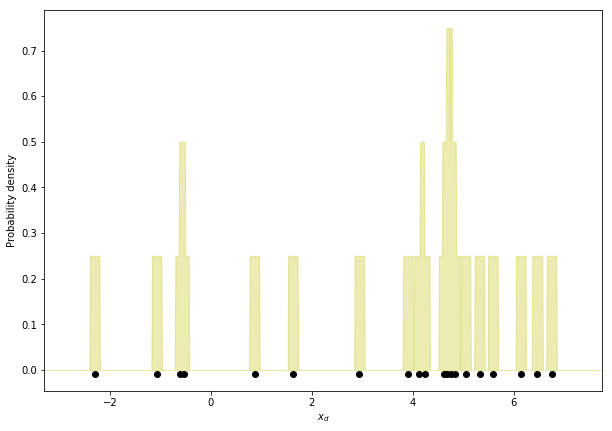

In [45]:
showexperiment(bounds=[-3.301,7.74481], bandwidth=.1, scale=1,offset=0,kernel = 'tophat')    

## Normal distribution on a circle

The probability density function of a normal distribution on a circle can be approximated (not exactly the same, but close) by the [von Mises distribution](https://en.wikipedia.org/wiki/Von_Mises_distribution)

This section experiments with the normal curve, but 'folded over', and bounded to within $\pm\pi$.  In other words the tails of normal distribution fold over into adjacent revolutions. Because of the bounding, it is expected that the bounded normal calculated with PDE should roughly correspond in shape to some von Mises curve.  If the two cases matches reasonably, we can probably trust the algorithm and specifically the folding around.

When doing these experiments, the nature of random numbers became apparent, yet again.  Small sample sizes are not always representative of the underlying model from which this dataset arises.  In the final test below it was necessary to use 100000 samples to achieve an acceptably rotationally symmetric PDF.

In the final analysis the von Mises and KDE densities differ quite substantially. What we don't know is what WikiPedia means by 'a close approximation', when is it close?

### Creating the data set

The data set is created to flow over at the boundaries, the out-of-bound data is not set to zero, one revolution ($2\pi$) is either added or subtracted. This folding over is only done for a single revolution, assuming that we will never require a second cycle fold over.

In [46]:
def make_data2(N, lothres=-1e300, hithres=1e300, stddev=1, rseed=1):
    rand = np.random.RandomState(rseed)
    x = stddev * rand.randn(N) #mean-0 var=1
    # Chop off the wings
    x = np.where(x>=hithres, x-2*np.pi , x)
    x = np.where(x<=lothres, x+2*np.pi , x)
    return x

In [47]:
# helper function to set up experiments
def showexperiment2(bounds=(np.nan,np.nan),bandwidth=np.nan,kernel='gaussian', stddev=1,numpoints=2000,rseed=1):
    
    if not np.isnan(bounds[0]) and not np.isnan(bounds[1]):
        lowbnd = bounds[0]
        uppbnd = bounds[1]
        x = make_data2(numpoints,lothres=bounds[0],hithres=bounds[1],stddev=stddev,rseed=rseed) 
        x_d = np.linspace(lowbnd,uppbnd, 1000)
    else:
        lowbnd = np.nan
        uppbnd = np.nan
        x = make_data2(numpoints,lothres=-1e300,hithres=1e300,stddev=stddev,rseed=rseed) 
        tenp = (np.max(x) - np.min(x)) / 10
        x_d = np.linspace(np.min(x)-5*tenp,np.max(x)+5*tenp, 1000)

    x_d,kde,bandwidth,kernel = KDEbounded(x_d,x,bandwidth=bandwidth,lowbnd=lowbnd,uppbnd=uppbnd, kernel=kernel)

    # for some reason the first and last element of kde are both zero, copy nonzero in 
    if kde[0]==0:
        kde[0] = kde[1]
    if kde[-1]==0:
        kde[-1] = kde[-2]
#     print(kde[0:10])
#     print(kde[-10:-1])
    
    print(f'stddev={stddev}')
    print(f'x.min={np.min(x):.4e}  x.max={np.max(x):.4e} x.shape={x.shape}')
    print(f'x.min={np.min(x_d):.4e}  x.max={np.max(x_d):.4e} x.shape={x_d.shape}')
    print(f'Bandwidth={bandwidth}')
    print(f'kernel={kernel}')
    print(f'Integral of PDF={np.trapz(kde,x_d)}')
    print(f'Minimum of PDF={np.min(kde)}')
    print(f'Maximum of PDF={np.max(kde)}')

    plt.figure(figsize=(10,7))
    plt.fill_between(x_d, kde, alpha=0.3,color='y')
    plt.plot(x, np.full_like(x, -0.011*np.max(kde)), '|k', markeredgewidth=1)
    plt.xlim(np.min(x_d),np.max(x_d))
    plt.xlabel('$x_d$')
    plt.ylabel(f'Probability density')
    plt.grid()
    return x_d,kde

By experimentation the following values of bandwidth were determined:

In [48]:
cases={
    1:{'stddev':0.35,'bandwidth':0.126},
    2:{'stddev':1.0,'bandwidth':0.368},
    3:{'stddev':1.5,'bandwidth':0.559},
}

In [49]:
# case = 3
# _,_ = showexperiment2(bounds=(np.nan,np.nan),bandwidth=np.nan, numpoints=200,
#                 kernel ='gaussian',stddev =cases[case]['stddev'])  

### Normal distribution on ${\rm I\!R}$

First plot the KDE for an unbounded case.  

The data set in this case is not manipulated to other values beyond $\pm\pi$.

stddev=0.35
x.min=-1.1612e+00  x.max=9.7761e-01 x.shape=(2000,)
x.min=-2.2306e+00  x.max=2.0470e+00 x.shape=(1000,)
Bandwidth=0.126
kernel=gaussian
Integral of PDF=0.9999999999999623
Minimum of PDF=3.873710297824752e-19
Maximum of PDF=1.1191587933746645


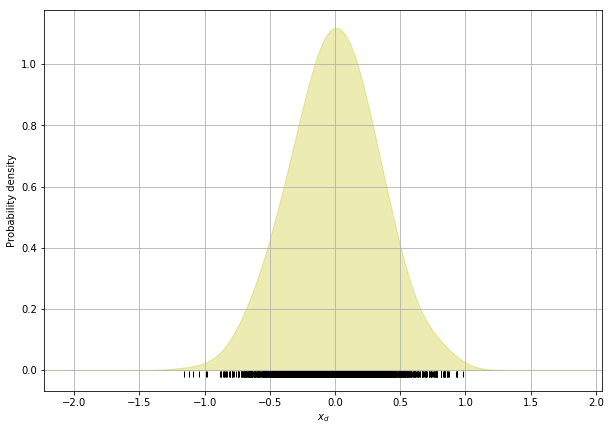

In [50]:
case = 1
_,_ = showexperiment2(bounds=(np.nan,np.nan), bandwidth=cases[case]['bandwidth'],
                kernel='gaussian', stddev=cases[case]['stddev'],rseed=10) 

stddev=1.0
x.min=-3.3177e+00  x.max=2.7932e+00 x.shape=(2000,)
x.min=-6.3731e+00  x.max=5.8486e+00 x.shape=(1000,)
Bandwidth=0.368
kernel=gaussian
Integral of PDF=0.9999999999999641
Minimum of PDF=6.299845374623026e-19
Maximum of PDF=0.390563672874331


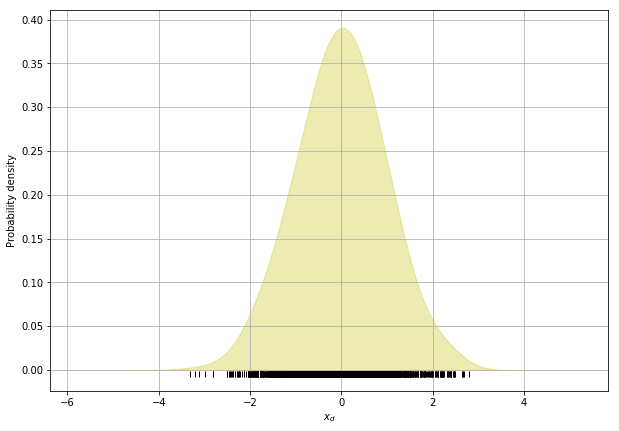

In [51]:
case = 2
_,_ = showexperiment2(bounds=(np.nan,np.nan), bandwidth=cases[case]['bandwidth'],
                kernel='gaussian', stddev=cases[case]['stddev'],rseed=10) 

stddev=1.5
x.min=-4.9765e+00  x.max=4.1897e+00 x.shape=(2000,)
x.min=-9.5596e+00  x.max=8.7729e+00 x.shape=(1000,)
Bandwidth=0.559
kernel=gaussian
Integral of PDF=0.9999999999999649
Minimum of PDF=9.834563153834013e-19
Maximum of PDF=0.2599253990823465


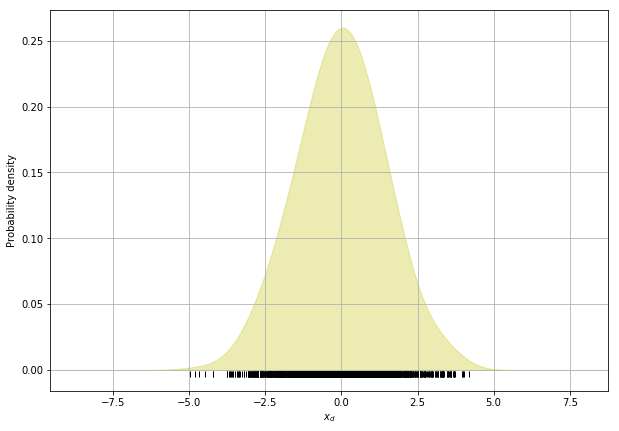

In [52]:
case = 3
_,_ = showexperiment2(bounds=(np.nan,np.nan), bandwidth=cases[case]['bandwidth'],
                kernel='gaussian', stddev=cases[case]['stddev'],rseed=10)  

### Normal distribution on the circle

stddev=0.35
x.min=-1.1612e+00  x.max=9.7761e-01 x.shape=(2000,)
x.min=-3.1416e+00  x.max=3.1416e+00 x.shape=(1000,)
Bandwidth=0.126
kernel=gaussian
Integral of PDF=0.9999999999999623
Minimum of PDF=3.9555763064137034e-67
Maximum of PDF=1.119152693208023


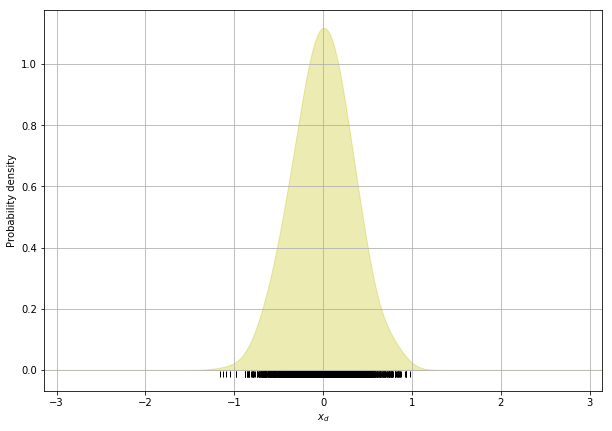

In [53]:
case = 1
_,_ = showexperiment2(bounds=(-np.pi,+np.pi), bandwidth=cases[case]['bandwidth'],
                kernel='gaussian', stddev=cases[case]['stddev'],rseed=10)  

stddev=1.0
x.min=-3.1126e+00  x.max=3.0788e+00 x.shape=(2000,)
x.min=-3.1416e+00  x.max=3.1416e+00 x.shape=(1000,)
Bandwidth=0.368
kernel=gaussian
Integral of PDF=1.0000000088109506
Minimum of PDF=0.006240401636832349
Maximum of PDF=0.3905647345367386


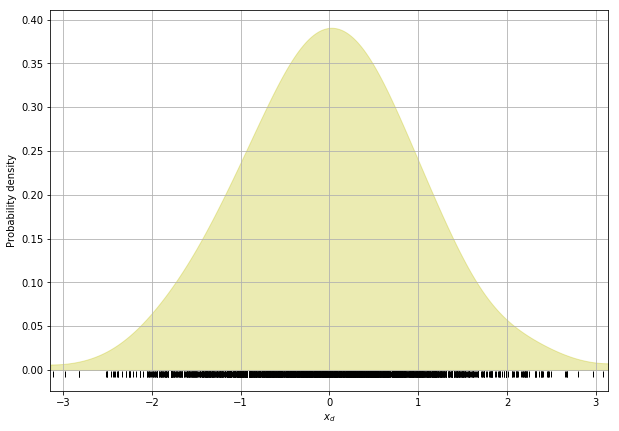

In [54]:
case = 2
_,_ = showexperiment2(bounds=(-np.pi,+np.pi), bandwidth=cases[case]['bandwidth'],
                kernel='gaussian', stddev=cases[case]['stddev'],rseed=10) 



stddev=1.5
x.min=-3.1416e+00  x.max=3.1415e+00 x.shape=(100000,)
x.min=-3.1416e+00  x.max=3.1416e+00 x.shape=(1000,)
Bandwidth=0.559
kernel=gaussian
Integral of PDF=1.0000000099625184
Minimum of PDF=0.07228754892836484
Maximum of PDF=0.250116115788818


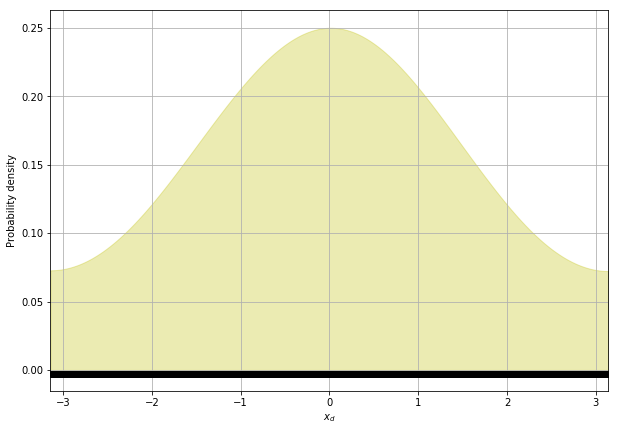

In [55]:
case = 3
x_d,kde = showexperiment2(bounds=(-np.pi,+np.pi), bandwidth=cases[case]['bandwidth'],
                kernel='gaussian', stddev=cases[case]['stddev'],rseed=10,numpoints=100000)  

### Compare with von Mises

0.25604669706055133
0.08525414527659232


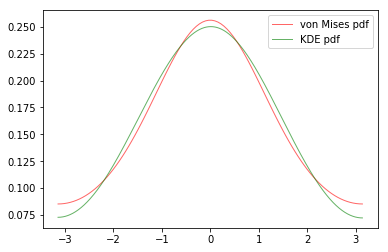

In [56]:
from scipy.stats import vonmises
sigma = 1
kappa = 0.55
mean, var, skew, kurt = vonmises.stats(kappa, moments='mvsk')
x = np.linspace(-np.pi,np.pi, 100)
p =  vonmises.pdf(x, kappa)
plt.plot(x,p,'r-', lw=1, alpha=0.6, label='vonmises pdf')
plt.plot(x_d,kde,'g-', lw=1, alpha=0.6, label='KDE pdf');
plt.legend(['von Mises pdf','KDE pdf']);
print(np.max(p))
print(np.min(p))


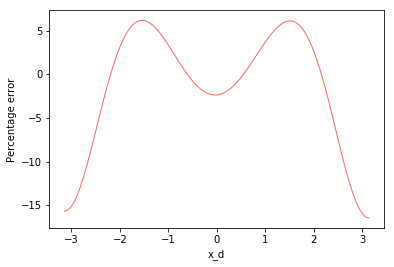

In [57]:
from scipy import interpolate
f = interpolate.interp1d(x_d, kde)
kden = f(x)

error = 100 * 2 *(f(x) - p)/ (f(x) + p)
plt.plot(x,error,'r-', lw=1, alpha=0.6, label='vonmises pdf');
plt.xlabel('x_d');
plt.ylabel('Percentage error');

## Conclusion

It seems that the scikit learn KDE algorithm as used here works acceptably.

There is much more to learn on the topic than what is covered here.  See the references at the top of the page.


## Python and [module versions, and dates](https://github.com/rasbt/watermark)

In [58]:
## to get software versions
# https://github.com/rasbt/watermark
# https://github.com/rasbt/watermark/blob/master/docs/watermark.ipynb
# you only need to do this once
# pip install watermark

%load_ext watermark
# %watermark -v -m -p numpy,scipy,pyradi -g -d
%watermark -v -m -p numpy,scipy,pyradi,pandas,sklearn -g -r -u -d -b -i

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
last updated: 2019-05-23 2019-05-23T21:12:10+02:00

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
scipy 1.1.0
pyradi 1.1.4
pandas 0.23.4
sklearn 0.20.1

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : 4440adb8b52bc8d3a5eef7468eca5f666c852e4d
Git repo   : https://github.com/NelisW/PythonNotesToSelf.git
Git branch : master
